In [65]:
import numpy as np
import matplotlib.pyplot as plt
import velocyto as vcy
from sklearn.manifold import TSNE
from sklearn.manifold import JTSNEBASE, JTSNE
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [90]:
expr_mat = pd.read_csv('data/snare_seq/GSE126074_CellLineMixture_SNAREseq_cDNA_counts.tsv', sep='\t')

In [91]:
atac_mat = pd.read_csv('data/snare_seq/GSE126074_CellLineMixture_SNAREseq_chromatin_counts.tsv', sep = '\t')

In [92]:
#atacTopic_mat = pd.read_csv('data/snare_seq/GSE126074_CellLineMixture_SNAREseq_chromatin_topics.tsv', sep = '\t')
#atac_mat.to_csv('data/snare_seq/GSE126074_CellLineMixture_SNAREseq_chromatin_noheader.tsv', sep='\t', index=False, header=True)

In [93]:
expr_mat.shape, atac_mat.shape

((18666, 1047), (136771, 1047))

# pre-processing gene expression data

In [94]:
scale_factor = 10000
expr_mat_log_t = np.log(scale_factor*expr_mat.values + 1.0)

In [95]:
expr_reduced = PCA(n_components=20).fit_transform(expr_mat_log_t.T)

In [96]:
joint_tsne_obj = TSNE(init='random')
joint_tsne = joint_tsne_obj.fit_transform(expr_reduced)

In [97]:
joint_tsne_obj.kl_divergence_

0.7253132462501526

In [98]:
from anndata import AnnData
import scanpy.api as sc
adata = AnnData(X=expr_reduced)
sc.pp.neighbors(adata, use_rep='X')
sc.tl.louvain(adata, key_added='louvain', resolution = 0.2)
louv_labels = np.array(adata.obs['louvain'].tolist())
louv_labels = [int(x) for x in louv_labels]

In [99]:
np.unique(louv_labels)

array([0, 1, 2, 3])

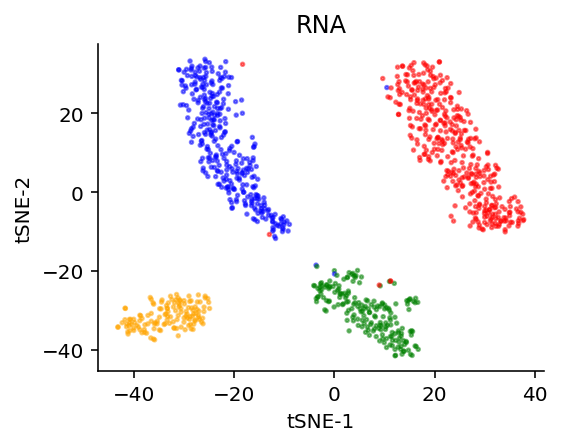

In [106]:
from matplotlib.colors import ListedColormap
colours = ListedColormap(['r','b','g', 'orange'])
classes = ['H1', 'BJ', 'K562', 'GM12878']
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
scatter = ax.scatter(joint_tsne[:,0], joint_tsne[:,1],s=3 , c = louv_labels, alpha=0.5, cmap=colours)
#ax.legend(handles=scatter.legend_elements()[0], labels=classes, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
ax.set_xlabel('tSNE-1')
ax.set_ylabel('tSNE-2')
ax.set_title('RNA')
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.savefig('/data/hoan/plots/snare_tsne_RNA.png', bbox_inches='tight')
plt.show()

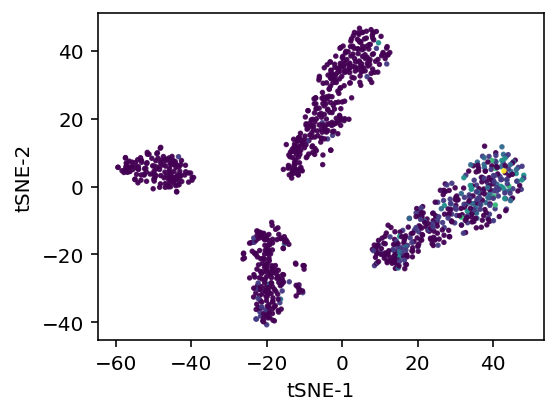

In [62]:
# Annotation of cell types based on known marker genes
plt.figure(figsize=(4,3))
# expr_mat.loc['HLA-DRB1']: 'GM12878', expr_mat.loc['COL1A2']: BJ, expr_mat.loc['EPCAM']: H1
plt.scatter(joint_tsne[:,0], joint_tsne[:,1],s=3 , c = expr_mat.loc['EPCAM'], alpha=0.9) 
plt.xlabel('tSNE-1')
plt.ylabel('tSNE-2')
plt.show()

# ATAC-seq

In [66]:
atacTopic_mat = pd.read_csv('data/snare_seq/GSE126074_CellLineMixture_SNAREseq_chromatin_topics.tsv', sep = '\t') 

In [67]:
atac_reduced = PCA(n_components=10).fit_transform(atacTopic_mat.values.T)

In [68]:
atac_reduced.shape

(1047, 10)

In [74]:
tsne_obj = TSNE(init='pca')
tsne = tsne_obj.fit_transform(atac_reduced)

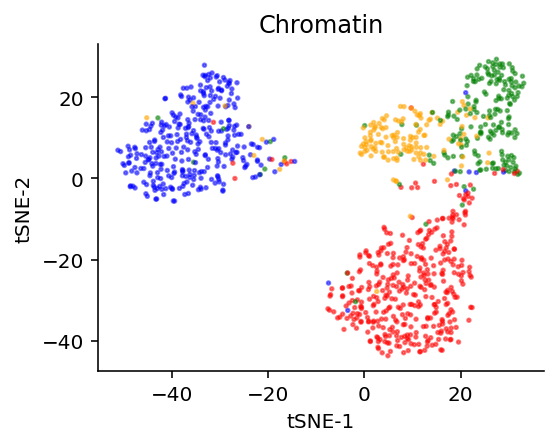

In [105]:
colours = ListedColormap(['r','b','g', 'orange'])
classes = ['H1', 'BJ', 'K562', 'GM12878']

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
scatter = ax.scatter(tsne[:,0], tsne[:,1],s=3 , c = louv_labels, alpha=0.5, cmap=colours)
#ax.legend(handles=scatter.legend_elements()[0], labels=classes, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
ax.set_xlabel('tSNE-1')
ax.set_ylabel('tSNE-2')
ax.set_title('Chromatin')
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.savefig('/data/hoan/plots/snare_tsne_Chromatin.png', bbox_inches='tight')
plt.show()

# Joint visualization

In [107]:
data = {'RNA': expr_reduced, 'Chromatin': atac_reduced}
joint_tsne = JTSNE(init='random').fit_transform(data)

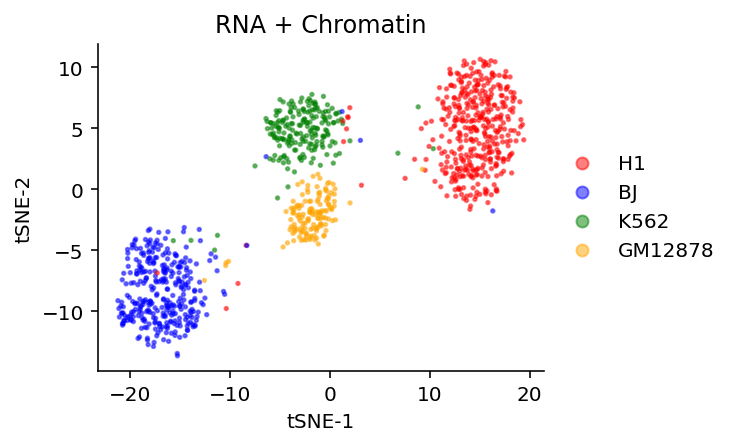

In [108]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
scatter = ax.scatter(joint_tsne[:,0], joint_tsne[:,1],s=3 , c = louv_labels, alpha=0.5, cmap=colours)
lgd = ax.legend(handles=scatter.legend_elements()[0], labels=classes, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
ax.set_xlabel('tSNE-1')
ax.set_ylabel('tSNE-2')
ax.set_title('RNA + Chromatin')
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.savefig('/data/hoan/plots/snare_tsne_RNA_Chromatin.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()